## Линейная регрессия: переобучение и регуляризация

В этом задании на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Имеем вещественные, бинарные и номинальные (порядковые) признаки, со всеми из них можно работать как с вещественными (с номинальныеми признаками, потому что на них задан порядок). Посмотрим на графиках, как целевой признак зависит от остальных

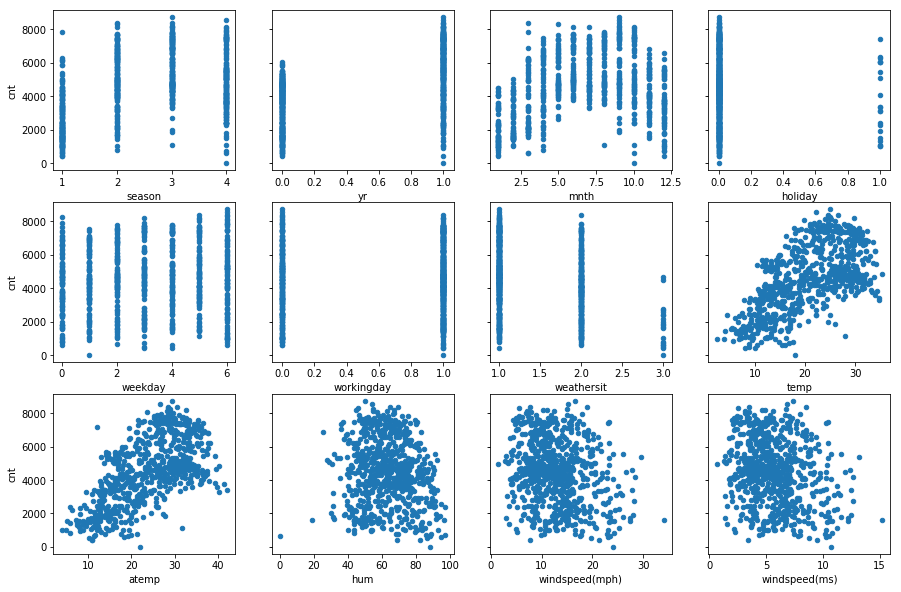

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(x=feature, y="cnt", subplots=True, kind="scatter", sharey=True, ax=axes[idx // 4, idx % 4])

__Блок 1__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: параболическая
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: temp, atemp. Причем Direction is positive, strength is weak and there're outliers

Более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [502]:
pd.DataFrame(df.iloc[:,:-1].corrwith(df.cnt, method='pearson').values.reshape(1,-1),index=['cnt'],columns=df.columns[:-1])

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
cnt,0.4061,0.56671,0.279977,-0.068348,0.067443,0.061156,-0.297391,0.627494,0.631066,-0.100659,-0.234545,-0.234545


В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому посчитаем корреляции между вещественными признаками (temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt).

In [503]:
df[['temp','atemp','hum','windspeed(mph)','windspeed(ms)','cnt']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [504]:
pd.DataFrame(df.mean().values.reshape(1,-1),index=['mean'],columns=data.columns)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
mean,2.49658,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,20.310776,23.717699,62.789406,12.762576,5.70522,4504.348837


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [505]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [463]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]].astype(float))
y = df_shuffled["cnt"]

Обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [464]:
from sklearn.linear_model import LinearRegression

In [491]:
linreg = LinearRegression()
linreg.fit(X,y)
dict(zip(df.columns[:-1],linreg.coef_))

{'season': 570.8675887934525,
 'yr': 1021.9652921309369,
 'mnth': -141.30438378580345,
 'holiday': -86.75613647415624,
 'weekday': 137.22482362623418,
 'workingday': 56.39056950314733,
 'weathersit': -330.2332887484121,
 'temp': 367.47338726750786,
 'atemp': 585.5559979631937,
 'hum': -145.6063153911189,
 'windspeed(mph)': 12458200269331.953,
 'windspeed(ms)': -12458200269530.414}

Видно, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуация называются _проблемой мультиколлинеарности_.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

Обучим регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [466]:
from sklearn.linear_model import Lasso, Ridge

In [492]:
linreg_lasso = Lasso()
linreg_lasso.fit(X,y)
dict(zip(df.columns[:-1],linreg_lasso.coef_))

{'season': 560.2416160308866,
 'yr': 1019.4634940657194,
 'mnth': -128.73062703678735,
 'holiday': -86.15278133371089,
 'weekday': 137.34789390496329,
 'workingday': 55.212370641356586,
 'weathersit': -332.3698569623483,
 'temp': 376.3632362096979,
 'atemp': 576.5307935045518,
 'hum': -144.1291550034862,
 'windspeed(mph)': -197.1396894024856,
 'windspeed(ms)': -2.8050001994027472e-08}

In [493]:
linreg_ridge = Ridge()
linreg_ridge.fit(X,y)
dict(zip(df.columns[:-1],linreg_ridge.coef_))

{'season': 563.0645722520175,
 'yr': 1018.9483787875301,
 'mnth': -131.873320282477,
 'holiday': -86.74609799709219,
 'weekday': 138.0051111787191,
 'workingday': 55.90311037506478,
 'weathersit': -332.34978849907395,
 'temp': 386.4578891919065,
 'atemp': 566.3470470600686,
 'hum': -145.07132729867178,
 'windspeed(mph)': -99.25944108179063,
 'windspeed(ms)': -99.25944115434177}

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

In [469]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1]))
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
for i, a in enumerate(alphas):
    coefs_lasso[i] = Lasso(alpha=a).fit(X,y).coef_
    coefs_ridge[i] = Ridge(alpha=a).fit(X,y).coef_

Визуализируем динамику весов при увеличении параметра регуляризации:
Напишем, функцию _VisualizeDependWeightFromAlpha_, которая в соответсвующей из 2-х областей отрисовывает графики зависимости весов признаков от alpha.

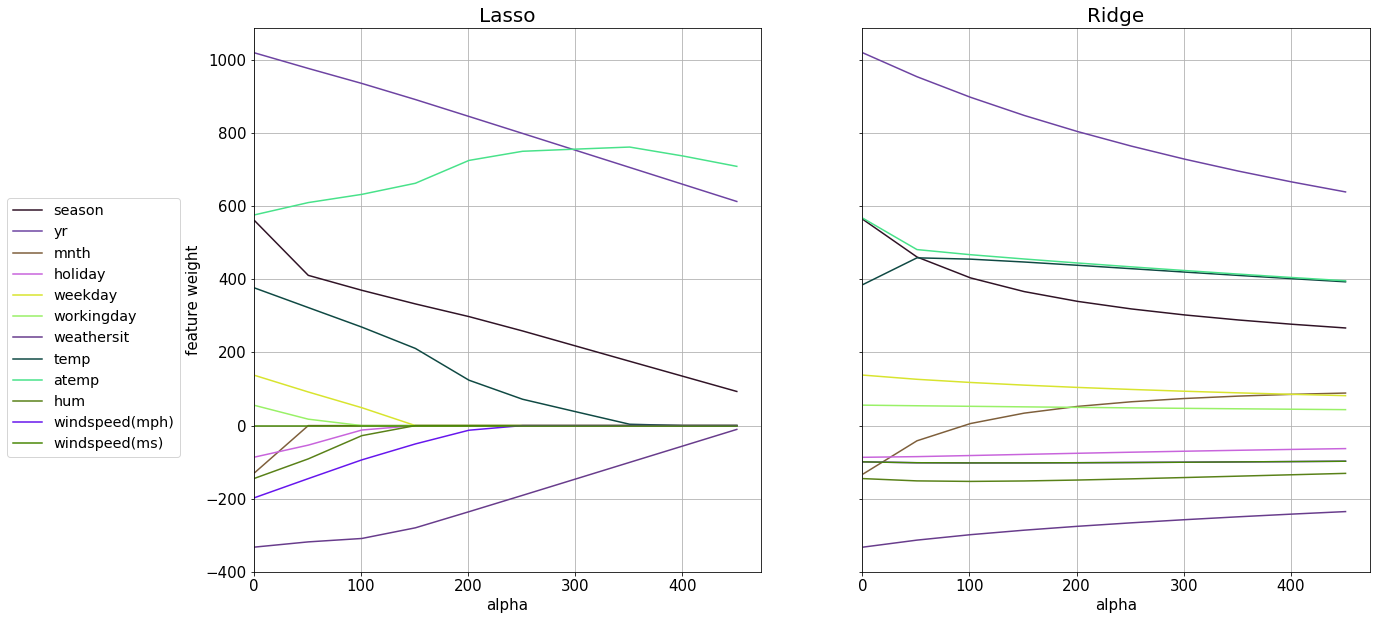

In [470]:
def VisualizeDependWeightFromAlpha(name, coefs, colors):
    k = 0 if name == 'Lasso' else 1
    for i, (coef, feature) in enumerate(zip(coefs.T, df.columns)):
        ax[k].plot(alphas, coef, label=feature, color=colors[i])
    if name == 'Lasso':
        ax[k].set_ylabel("feature weight",fontsize=15)
        ax[k].legend(loc='upper left',fontsize='x-large', bbox_to_anchor=(-0.5, 0.7))
    ax[k].set_xlabel("alpha",fontsize=15)
    ax[k].set_title(name,fontsize=20)
    ax[k].tick_params(labelsize=15)
    ax[k].set_xlim(left=0)
    ax[k].grid(True)

fig, ax = plt.subplots(nrows=1, ncols=2,sharey=True, figsize=(20,10))
colors = [np.random.rand(3) for _ in range(len(df.columns)-1)]
VisualizeDependWeightFromAlpha('Lasso',coefs_lasso, colors)
VisualizeDependWeightFromAlpha('Ridge',coefs_ridge, colors)
plt.show()

__Блок 2__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ: Lasso
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: Получится очень сильный регулризатор в связи с чем, алгоритму гораздо выгоднее для решения задачи минимизации занулять все больше и больше весов (видно из графика), что в конце концов приведет к тому, что обнулятся все веса.
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ: Lasso исключает windspeed(ms) при любом значении alpha > 0, в случае с Ridge данного эффекта не наблюдается, веса уменьшаются и им присваиваются одинаковые веса, судя по полученным значениям,
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: Lasso, как видно из графиков и из массива coefs_lasso

Далее будем работать с **Lasso**.

Итак, мы видим, что при изменении **alpha** модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее **alpha**. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть **Mean Square Error**.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать **alpha** по значению **MSE** на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения **alpha**, а затем усреднять **MSE**. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Используем регрессор __LassoCV__ для проведения кросс-валидация метода __Lasso__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, (k - число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной __alpha\___ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому __alpha\___.

Регрессор может менять порядок, в котором он проходит по **alphas**; для сопоставления с матрицей MSE лучше использовать переменную регрессора **alphas_**.

Обучим регрессор LassoCV на всех параметрах регуляризации из **alphas**. Построим график _усредненного_ по строкам MSE в зависимости от **alpha**. 
Выведем выбранное **alpha**, а также пары "признак-коэффициент" для обученного вектора коэффициентов

In [471]:
from sklearn.linear_model import LassoCV

Напишем функцию _VisualizeDepenMSEFromAlpha_, которая строит график **_MSE(alpha)_**

In [472]:
def VisualizeDepenMSEFromAlpha(x, y, i=-1):
    plt.figure(figsize=(10,8))
    plt.plot(x, y, linewidth=2.5)
    if i == -1:
        plt.title(r'Dependency MSE from $\alpha$', fontsize=20)
    else:
        plt.title(r'Dependency MSE from $\alpha$ for %i column' % i, fontsize=20)
    plt.ylabel('MSE', fontsize=18)
    plt.xlabel(r'$\alpha$', fontsize=18)
    plt.xticks(alphas)
    plt.xlim(left=min(x), right=max(x))
    plt.ylim(top=max(y))
    plt.grid(True)
    plt.show()

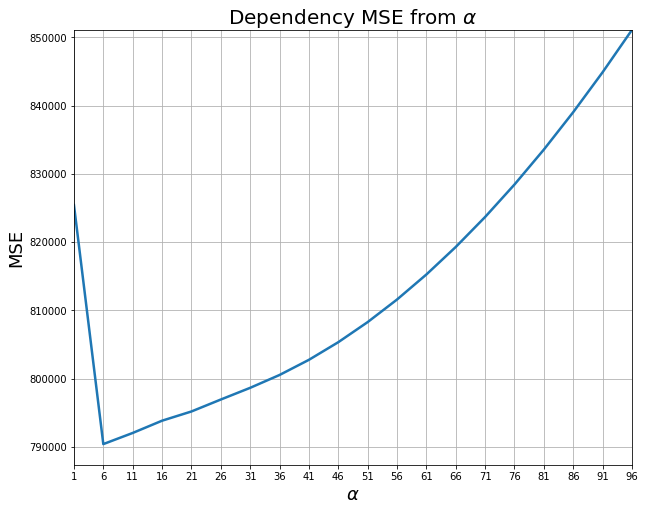

Best alpha = 6

{'season': 532.0189828413536, 'yr': 1015.0602226430599, 'mnth': -100.03952614356655, 'holiday': -83.29395987529932, 'weekday': 132.50446549095793, 'workingday': 51.5570856140738, 'weathersit': -330.5598567399813, 'temp': 370.679855030036, 'atemp': 581.3969310654961, 'hum': -140.00740550068872, 'windspeed(mph)': -191.77140847135075, 'windspeed(ms)': -2.6854295468291656e-08}


In [473]:
alphas = np.arange(1, 100, 5)
kfold=3
reg = LassoCV(alphas=alphas, cv=kfold, n_jobs=-1)
reg.fit(X,y)
VisualizeDepenMSEFromAlpha(reg.alphas_, reg.mse_path_.mean(axis=1))
print('Best alpha = {0}\n'.format(reg.alpha_))
print(dict(zip(df.columns[:-1], reg.coef_)))

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

Выведем значения **alpha**, соответствующие минимумам **MSE** на каждом разбиении (то есть по столбцам).
<br>
На трех отдельных графиках визуализируем столбцы **reg.mse_path_**

Alpha for min MSE = 843336.1814988204 for 1-st column = 41
Alpha for min MSE = 772598.4956277699 for 2-d column = 6
Alpha for min MSE = 745668.6059608046 for 3-d column = 1


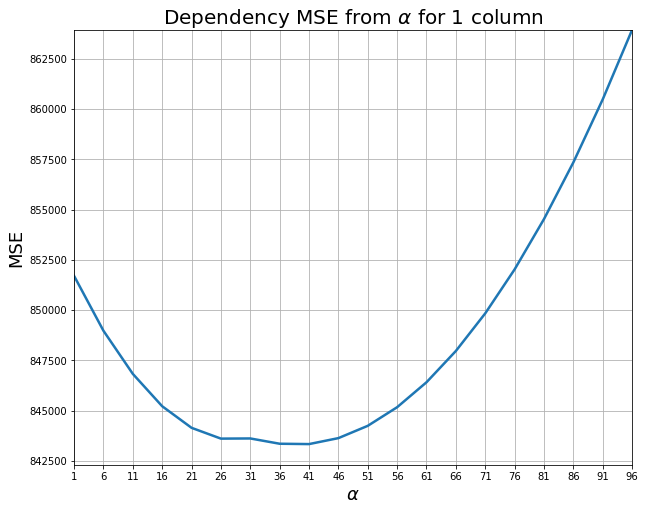

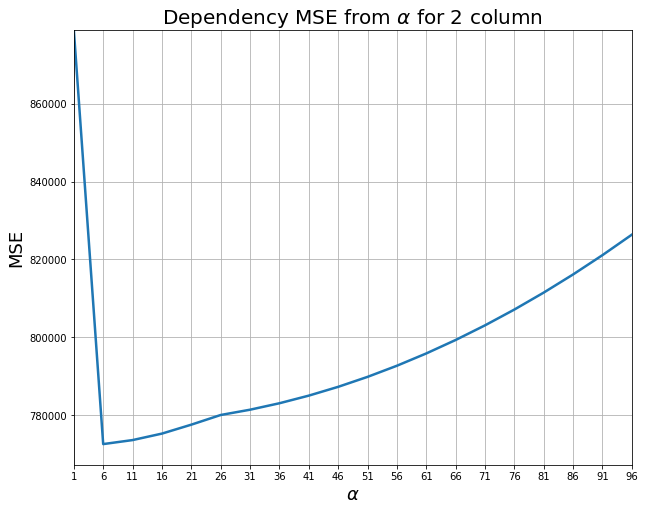

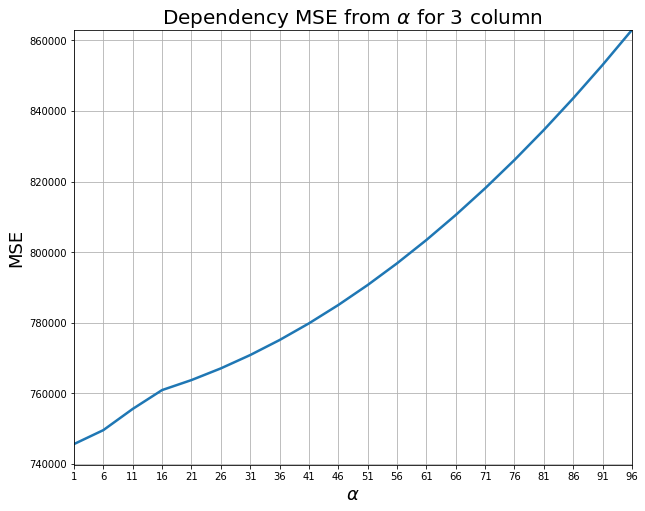

In [498]:
*a, = reg.alphas_[(np.argwhere(reg.mse_path_.min(axis=0)==reg.mse_path_))[:,0]]
*mse, = reg.mse_path_.min(axis=0)
print('Alpha for min MSE = {1} for 1-st column = {0}'.format(a[0], mse[0]), sep='\n')
print('Alpha for min MSE = {1} for 2-d column = {0}'.format(a[1], mse[1]), sep='\n')
print('Alpha for min MSE = {1} for 3-d column = {0}'.format(a[2], mse[2]))

for i in range(kfold):
    VisualizeDepenMSEFromAlpha(reg.alphas_, reg.mse_path_[:,i], i+1)

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 3__

Cоздадим словарь, содержащий признаки и их соответствующие коэффициенты из последней обученной модели.

In [475]:
feat_weights_dict = dict(zip(df.columns[:-1], reg.coef_))

Напишем функцию _get_feature_, возвращающую ключ-признак по своему значению-весу.
<br>
А также функию _NeededFeatures_, возвращающую словарь, содержащий необходимые масимальные/минимальные коэффициенты и признаки им соответствующие.

In [476]:
def get_feature(val):
    for k, v in feat_weights_dict.items(): 
        if abs(v - val) <= 1e-6 : 
            return k 

In [477]:
def NeededFeatures(k, string):
    if string == 'maxpositive':
        weights = reg.coef_[np.argsort(reg.coef_)[-k:]]
    elif string == 'minnegative':
        weights = reg.coef_[np.argsort(reg.coef_)[:k]]
    features = []
    for i in range(k):
        features.append(get_feature(weights[i]))
    return dict(zip(features, weights))

**1**

Берем 4 коэффициента с максимальными положительными значениями, находщиеся в конце отсортированного вектора значений и их признаки.

In [478]:
print(NeededFeatures(4, 'maxpositive'))

{'temp': 370.679855030036, 'season': 532.0189828413536, 'atemp': 581.3969310654961, 'yr': 1015.0602226430599}


**2**

Берем 3 коэффициента с максимальными по модулю отрицательными значениями, находщиеся в начале отсортированного вектора значений и их признаки.

In [479]:
print(NeededFeatures(3, 'minnegative'))

{'weathersit': -330.5598567399813, 'windspeed(mph)': -191.77140847135075, 'hum': -140.00740550068872}


**3**

In [480]:
d = {}
for k, v in feat_weights_dict.items():
    if abs(v) < 1e-3:
        d[k] = v
print(d)

{'windspeed(ms)': -2.6854295468291656e-08}



1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

    * Ответ: Возрастающая линейная зависимость cnt от найденных признаков и правда наблюдается на графиках. Исходя из здравого смысла нельзя утверждать, что при дальнейшем повышении значений признаков спрос также увеличится, так как признак season нельзя увеличить, это просто кодирование словом времен года, yr, конечно увеличить можно, полагая, что большим годам соответсвтует большее число и так с шагом=1, но сделать явного вывода по данному исследованию нельзя, необходимо более детальное. Аналогично с температурой, зависимость хоть и линейная, но наибольшее скопление точен лежит явно не при 40 градусах, а несколько ниже, здравый смысл тоже наводит на мысли, что при дальнейшем увилечении температуры, спрос будет падать. 
<br><br>
     **Вывод:** увеличение значений на признаках вещь относителньая, до определенного порога увеличивая температуру спрос будет расти, - да, но дальше, думаю, падать, про дальенйшие года сделать вывод на увеличение спроса нельзя. Про сезон исходя из 4х значений сказать можно, что чем выше число, тем выше спрос.
     <br><br>
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

    * Ответ: Убывающая линейная зависимость cnt от найденных признаков наблюдается, судя по графикам. Утверждать о том, что если величины данных признаков увеличиваются в пределах допустимых диапазонов, то спрос будет падать, можно, как исходя из здравого смысла, так и из графиков.
    <br><br>
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

    * Ответ: В данном случае модель Lasso исключила всего один признак windspeed(ms), так как он сильно зависим с признаком windspeed(mph) (это же просто перевод одних единиц измерения в другие). Можно сказать, что он никак не влияет на спрос на велосипеды лишь при наличии признака windspeed(mph), если же его убрать, то все влияние перейдет к windspeed(ms) и тогда сказать, что он никак не влияет на спрос на велосипеды нельзя.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.